In [15]:
import gymnasium as gym
import cookiedisaster
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
print(torch.__version__)

SEED=2
np.random.seed(SEED)

env = gym.make('cookiedisaster/GridWorld-v0')

2.2.2


#### seed vs not seed, doens't matter, still get random each time??

In [2]:
env.reset(seed=SEED) 

c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


({'agent': {'pos': 4, 'vel': 0.0},
  'cookie': {'pos': 0.10111663773625759, 'time': 5}},
 {'distance': 3.898883362263742, 'steps': 0})

#### get the observation:
- the agents pos and vel
- the cookies pos and time remaining

In [3]:
env.reset(seed=SEED)[0]

{'agent': {'pos': 4, 'vel': 0.0},
 'cookie': {'pos': 0.9194711828695544, 'time': 5}}

In [4]:
env.step(2)

c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


({'agent': {'pos': 4.2, 'vel': 1.0},
  'cookie': {'pos': 0.9194711828695544, 'time': 5}},
 0,
 False,
 False,
 {'distance': 3.280528817130446, 'steps': 1})

In [5]:
# env.render()
DUMMY_STATE=env.step(0)
MAX_TIME=5*25 # 5 cookies elapse time
PUNISHMENT=-1 # may have to be adjusted

# chat lets gooo

In [6]:
def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
    return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

def preprocess_state(state):
    # Assuming state is a dictionary like:
    # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
    robot_pos = normalize(state[0]['agent']['pos'], 0, 10)
    robot_vel = normalize(state[0]['agent']['vel'], -7, 7)
    cookie_pos = normalize(state[0]['cookie']['pos'], 0, 10)
    cookie_time = normalize(state[0]['cookie']['time'], 0, 5)
    distance = robot_pos - cookie_pos
    direction = 1 if distance > 0 else -1
    
    # Return the normalized state as a numpy array
    return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])


# def preprocess_state(state):
#     # Assuming state is a dictionary with the structure you've shown
#     agent_pos = state[0]['agent']['pos']
#     agent_vel = state[0]['agent']['vel']
#     cookie_pos = state[0]['cookie']['pos']
#     cookie_time = state[0]['cookie']['time']
#     distance = state[-1]['distance']
#     steps = state[-1]['steps']
    
#     # Combine these into a flat array of features
#     processed_state = np.array([agent_pos, agent_vel, cookie_pos, cookie_time, distance, steps])

#     return processed_state

def choose_action(state, weights, epsilon, num_actions):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)
    else:
        # print('state',state)
        # print('weights',weights)
        q_values = np.dot(state, weights)
        # print('q_values',q_values)
        return np.argmax(q_values)

def update_weights(state, action, reward, next_state, weights, learning_rate, discount_factor):
    next_action = choose_action(next_state, weights, 0, len(weights[0]))
    td_target = reward + discount_factor * np.dot(next_state, weights[:, next_action])
    td_error = td_target - np.dot(state, weights[:, action])
    weights[:, action] += learning_rate * td_error * state
    return weights


def train(env, num_episodes=10000, learning_rate=0.1, discount_factor=0.999, epsilon=0.3):
    num_actions = env.action_space.n
    num_features = env.observation_space.shape[0]  # Assuming Box space
    num_features = len(preprocess_state(DUMMY_STATE))  # Use an example or dummy initial state
    weights = np.zeros((num_features, num_actions))

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        count=0
        while not done:
            processed_state = preprocess_state(state)  # Process state
            action = choose_action(processed_state, weights, epsilon, num_actions)
            next_state= env.step(action)
            total_reward += next_state[1]

            processed_next_state = preprocess_state(next_state)  # Process next state
            weights = update_weights(processed_state, action, next_state[1], processed_next_state, weights, learning_rate, discount_factor)

            state = next_state
            # found cookie break
            if next_state[1]>0:
                break
            # missed 5 cookies (MAX_TIME), minus points and break
            if count>MAX_TIME:
                # env._cumulative_reward+=PUNISHMENT
                # total_reward+=PUNISHMENT
                break
            count+=1
            # if count>100:
            #     print('count',count)
            #     break
            
            if done:
                print(f"DONE! Episode {episode}, count {count}, Total Reward: {total_reward}")
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    print("Training finished.")
    return weights

def test(env, weights, num_episodes=500):
    state = env.reset()
    total_reward = 0
    total_rewards = []
    for _ in range(num_episodes):
        done = False
        

        # while not done:
        processed_state = preprocess_state(state)  # Process state
        action = choose_action(processed_state, weights, 0, len(weights[0]))
        state = env.step(action)
        total_reward += state[1]
            # if state[1]>0:
            #     # print(f'Episoned {episode}, count {count}, reward {next_state[1]}')
            #     break

        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    print(f"Average reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward, total_rewards

env = gym.make('cookiedisaster/GridWorld-v0')

# Train the agent
trained_weights = train(env)

Episode 0, Total Reward: -5.316062190712567


Episode 100, Total Reward: 0.5
Episode 200, Total Reward: 0.3327504983225351
Episode 300, Total Reward: 1
Episode 400, Total Reward: -0.9974756767772084
Episode 500, Total Reward: 1
Episode 600, Total Reward: -1.089508730677816
Episode 700, Total Reward: -1.0
Episode 800, Total Reward: 0.0
Episode 900, Total Reward: -1.0
Episode 1000, Total Reward: 0.5
Episode 1100, Total Reward: 1
Episode 1200, Total Reward: 0.5
Episode 1300, Total Reward: 0.5
Episode 1400, Total Reward: 1
Episode 1500, Total Reward: 1
Episode 1600, Total Reward: -2.5
Episode 1700, Total Reward: -2.5
Episode 1800, Total Reward: 0.5
Episode 1900, Total Reward: 1
Episode 2000, Total Reward: 1
Episode 2100, Total Reward: 1
Episode 2200, Total Reward: 0.5
Episode 2300, Total Reward: 1
Episode 2400, Total Reward: 1
Episode 2500, Total Reward: 1
Episode 2600, Total Reward: -2.0773491004469835
Episode 2700, Total Reward: 1
Episode 2800, Total Reward: 0.5
Episode 2900, Total Reward: -1.8222967886927366
Episode 3000, Total Rew

In [7]:

env = gym.make('cookiedisaster/GridWorld-v0',
            #    render_mode='human'
               )

# Test the agent
avg_func,func_rewards=test(env, trained_weights, num_episodes=100)
env.close()

Average reward over 100 episodes: -4.26258601925161


In [8]:
trained_weights

array([[-0.15253852, -0.24189452, -0.23474692],
       [ 0.19079199, -0.3134597 , -0.70424752],
       [-0.16657725, -0.0258768 , -0.20355156],
       [ 0.43376501,  0.28852999,  0.19494037],
       [ 0.01403873, -0.21601772, -0.03119535],
       [ 0.41139576,  0.36041718, -0.20901164]])

# chat Neural network !

In [9]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)
        # self.relu2 = nn.ReLU()
        # self.fc3 = nn.Linear(hidden_size, action_size)
    
    def forward(self, state):
        x = self.fc1(state)
        x = self.relu1(x)
        x = self.fc2(x)
        # x = self.relu2(x)
        # x = self.fc3(x)
        return x


In [10]:
env = gym.make('cookiedisaster/GridWorld-v0')
state_size = len(preprocess_state(DUMMY_STATE))  # Adjust this based on your preprocessing
action_size = env.action_space.n
q_network = QNetwork(state_size, action_size)
optimizer = optim.Adam(q_network.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [11]:
def train_q_network(env, q_network, episodes=1000, gamma=0.999):
    state = env.reset()
    state = preprocess_state(state)
    for episode in range(episodes):
        
          # Make sure to implement this
        done = False
        total_reward = 0
        count=0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = q_network(state_tensor)
            if np.random.rand() < 0.2:
                action = np.random.choice(env.action_space.n)
            else:
                action = torch.argmax(q_values).item()
            
            next_state = env.step(action)
            done=next_state[2]
            reward = next_state[1]
            
            # found cookie break
            if next_state[1]>0:
                break
            # missed 5 cookies (MAX_TIME), minus points and break
            if count>MAX_TIME:
                # env._cumulative_reward+=
                break
            count+=1
            
            next_state = preprocess_state(next_state)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

            if not done:
                max_next_q = torch.max(q_network(next_state_tensor))
                target_q = reward + gamma * max_next_q
            else:
                target_q = torch.tensor([reward])

            target_q_values = q_values.clone()
            target_q_values[0][action] = target_q

            loss = loss_fn(q_values, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward
        if episode % 100 == 0:
            print(f'Episode: {episode}, Total Reward: {total_reward}')
    return q_network



def test_q_network(env, q_network, episodes=500):
    state = env.reset()
    total_rewards = []
    total_reward = 0
    for _ in range(episodes):
        
        done = False
        

        
        state = preprocess_state(state)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = q_network(state_tensor)
        action = torch.argmax(q_values).item()

        next_state= env.step(action)
        total_reward += next_state[1]
        state = next_state

        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    return avg_reward,total_rewards


In [12]:
env = gym.make('cookiedisaster/GridWorld-v0')
trained_network=train_q_network(env, q_network)

c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:

Episode: 0, Total Reward: -5.880443462160555
Episode: 100, Total Reward: 0
Episode: 200, Total Reward: -1.142791068551932
Episode: 300, Total Reward: -2.089126268241992
Episode: 400, Total Reward: -0.504324725700727
Episode: 500, Total Reward: 0
Episode: 600, Total Reward: -4.215241673603466
Episode: 700, Total Reward: 0
Episode: 800, Total Reward: -3.3967422417762476
Episode: 900, Total Reward: -4.1444069683321825


In [13]:
env=gym.make('cookiedisaster/GridWorld-v0',render_mode='human')
avg_nn,nn_rewards=test_q_network(env, trained_network)
env.close()

In [14]:
env = gym.make('cookiedisaster/GridWorld-v0')
avg_func,func_rewards=test(env, trained_weights, num_episodes=500)

Average reward over 500 episodes: -13.197474226751552


c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:

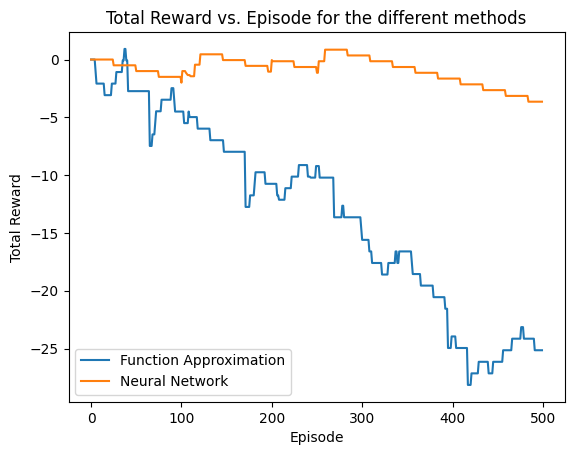

In [17]:
plt.plot(func_rewards, label='Function Approximation')
plt.plot(nn_rewards, label='Neural Network')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs. Episode for the different methods') 
plt.legend()
plt.show()

In [19]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, state):
        return self.network(state)


In [20]:


SEED=2
np.random.seed(SEED)

env = gym.make('cookiedisaster/GridWorld-v0')

env.reset(seed=SEED) 
# env.render()
DUMMY_STATE=env.step(0)
MAX_TIME=5*25 # 5 cookies elapse time
PUNISHMENT=-1 # may have to be adjusted

def normalize(value, min_value, max_value, scale_min=-1, scale_max=1):
    return ((value - min_value) / (max_value - min_value)) * (scale_max - scale_min) + scale_min

def preprocess_state(state):
    # Assuming state is a dictionary like:
    # {'robot': {'pos': x, 'vel': y}, 'cookie': {'pos': z, 'time': w}}
    robot_pos = normalize(state[0]['agent']['pos'], 0, 10)
    robot_vel = normalize(state[0]['agent']['vel'], -7, 7)
    cookie_pos = normalize(state[0]['cookie']['pos'], 0, 10)
    cookie_time = normalize(state[0]['cookie']['time'], 0, 5)
    distance = robot_pos - cookie_pos
    direction = 1 if distance > 0 else -1
    
    # Return the normalized state as a numpy array
    return np.array([robot_pos, robot_vel, cookie_pos, cookie_time,distance, direction])


class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, state):
        return self.network(state)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, state):
        return self.network(state)

input_dim = 6  # From preprocess_state function
output_dim = env.action_space.n

actor = Actor(input_dim, output_dim)
critic = Critic(input_dim)


actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)

num_episodes = 1000
gamma = 0.99  # Discount factor for future rewards

episode_rewards = []  # Track rewards per episode
action_counts = np.zeros(output_dim)
def train_actor_critic(env, num_episodes=10, gamma=0.99, actor_lr=0.001, critic_lr=0.001):
    # Environment and model parameters
    input_dim = 6  # From preprocess_state function
    output_dim = env.action_space.n

    # Initialize models
    actor = Actor(input_dim, output_dim)
    critic = Critic(input_dim)

    # Initialize optimizers
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    
    # Training loop
    
    
    for episode in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0
        epsilon_start = 1.0
        epsilon_min = 0.01
        epsilon_decay = 0.995

        while not done:
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            epsilon = max(epsilon_min, epsilon_start * epsilon_decay**episode)
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                action = distribution.sample()
            
            action_counts[action] += 1
            next_state= env.step(action.item())
            reward = next_state[1]
            done = next_state[2]
            
            if next_state[1]>0:
                break
            # missed 5 cookies (MAX_TIME), minus points and break
            if count>MAX_TIME:
                # env._cumulative_reward+=PUNISHMENT
                # total_reward+=PUNISHMENT
                break
            count+=1
            # if count>100:
            #     print('count',count)
            #     break
            
            next_state = preprocess_state(next_state)
            
            total_reward += reward
            
            # Critic update
            value = critic(state_tensor)
            next_value = critic(torch.FloatTensor(next_state).unsqueeze(0))
            td_error = reward + gamma * next_value * (1 - int(done)) - value
            critic_loss = td_error.pow(2)
            
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            # Actor update
            action = torch.tensor(action)
            actor_loss = -distribution.log_prob(action) * td_error.detach()
            
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            
            state = next_state
            
        
        episode_rewards.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    return actor, critic, episode_rewards, action_counts, episode_rewards

def evaluate_policy(env, actor, num_episodes=100):
    total_rewards = 0.0
    rewards = []    
    for _ in range(num_episodes):
        state = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0
        count = 0

        while not done:
            if count > MAX_TIME:  # Break if max time exceeded without positive reward
                break
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = actor(state_tensor)
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()
            
            next_state= env.step(action.item())
            reward = next_state[1]
            rewards.append(reward)
            done = next_state[2]
            
            if next_state[1]>0:
                break
            
            if count>MAX_TIME:
                
                break
            count+=1
          
            
            next_state = preprocess_state(next_state)
            
            
            total_reward += reward

       

    average_reward = total_rewards / num_episodes
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    return average_reward, rewards

def find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, gamma=0.99, threshold_reward=None, max_iterations=10, eval_episodes=10):
    actor_lr = initial_actor_lr
    critic_lr = initial_critic_lr
    
    best_average_reward = float('-inf')
    best_actor = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}: Training Started")
        actor, critic, episode_rewards, action_counts, episode_rewards= train_actor_critic(env, num_episodes=num_episodes, gamma=gamma, actor_lr=actor_lr, critic_lr=critic_lr)
        average_reward, rewards = evaluate_policy(env, actor, num_episodes=eval_episodes)
        print(f"Iteration {iteration + 1}: Average Reward = {average_reward}")
        
        # Check if the current model is the best one
        if average_reward > best_average_reward:
            best_average_reward = average_reward
            best_actor = actor
            print("New best model found!")
            
            # Optional: Adjust learning rates based on performance, implement your strategy here
            # actor_lr *= learning_rate_decay
            # critic_lr *= learning_rate_decay
            
        # If a threshold is defined and met, stop training
        if threshold_reward is not None and average_reward >= threshold_reward:
            print(f"Desired threshold reward of {threshold_reward} achieved.")
            break
        
        # Optional: Implement additional logic to adjust training parameters or terminate early
    
    return best_actor, best_average_reward, rewards

best_actor, best_reward, rewards = find_optimal_policy(env, initial_actor_lr=0.001, initial_critic_lr=0.001, threshold_reward=-2.5, max_iterations=num_episodes)
print(f"Best average reward achieved: {best_reward}")


c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:

Iteration 1/1000: Training Started
Episode 0, Total Reward: 0


C:\Users\saraa\AppData\Local\Temp\ipykernel_8700\1578772765.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(action)


Episode 100, Total Reward: -6.442944874111422
Episode 200, Total Reward: -2.0935551779375707
Episode 300, Total Reward: -0.5
Episode 400, Total Reward: -2.5
Episode 500, Total Reward: -0.5
Episode 600, Total Reward: -1.5
Episode 700, Total Reward: -1.5
Episode 800, Total Reward: -0.5
Episode 900, Total Reward: -0.5
Average Reward over 10 episodes: 0.0
Iteration 1: Average Reward = 0.0
New best model found!
Desired threshold reward of -2.5 achieved.
Best average reward achieved: 0.0


In [21]:


def test_actor_critic(env, actor, episodes=num_episodes):
    total_rewards = []
    state = env.reset()
    total_reward = 0
    
    for _ in range(episodes):
        state = preprocess_state(state)  # Adjust based on your state preprocessing
        done = False
      
        count = 0
        
        
      
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = actor(state_tensor)
        action = torch.argmax(q_values).item()
        next_state= env.step(action)
        reward = next_state[1]
        done = next_state[2]    
        # next_state = preprocess_state(next_state)
        state = next_state
        total_reward += reward
        
        total_rewards.append(total_reward)
    
    avg_reward = np.mean(total_rewards)
    print(f"Average reward over {episodes} episodes: {avg_reward}")
    return avg_reward, total_rewards


In [25]:

env=gym.make('cookiedisaster/GridWorld-v0',render_mode='human')
avg_act, act_rewards=test_actor_critic(env, best_actor, episodes=500)
env.close()


c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:

Average reward over 500 episodes: 10.007802820460572


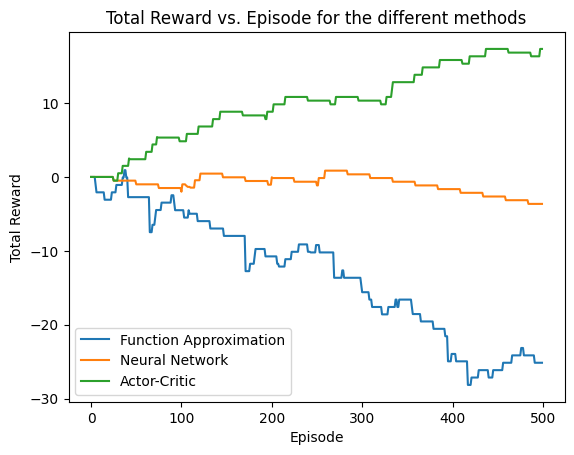

In [26]:
plt.plot(func_rewards, label='Function Approximation')
plt.plot(nn_rewards, label='Neural Network')
plt.plot(act_rewards, label='Actor-Critic')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs. Episode for the different methods')
plt.legend()
plt.show()